# VGG16 model

### VGG16 with TIRADs

## Get packages

In [10]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

## Paths

In [97]:
TRAIN_PATH = 'archive/classification/tirads/no_frame/balance/train'
TEST_PATH = 'archive/classification/tirads/no_frame/balance/test'
VALID_PATH = 'archive/classification/tirads/no_frame/balance/validate'

In [98]:
input_size = (3,224,224)

## Load and Prepare Images

In [99]:
# # for neaug frame
# # divisible with 258: 2, 3, 6, 43, 86, 129 
# train_batchsize = 6
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for aug frame
# # divisible with 518: 2, 259.
# train_batchsize = 2
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for balance frame
# # divisible with 426: 2, 3, 6, 71, 142, 213
# train_batchsize = 6
#  # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# # for neaug no frame
# # divisible with 258: 2, 3, 6, 43, 86, 129 
# train_batchsize = 6
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


# #for aug no frame
# # divisible with 518: 2, 259
# train_batchsize = 2
# # divisible with 52: 2, 4, 13 
# valid_batchsize = 4


#for balance no frane
# divisible with 426: 2, 3, 6, 71, 142, 213
train_batchsize = 6
# divisible with 18: 2, 3, 6, 9
valid_batchsize = 3


train_datagen = ImageDataGenerator(rescale=1./255
)

validation_datagen = ImageDataGenerator(rescale=1./255)
                                  
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
         batch_size=train_batchsize,
        target_size=input_size[1:],
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size=input_size[1:],
        shuffle=True,
         batch_size=valid_batchsize,
        class_mode='categorical')

Found 426 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


## Make the model

### From Scratch

In [100]:
# Define the model as a sequential sequence of layers
model = Sequential()

# Define convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Define classification layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# Print a summary of the model architecture
model.summary()


# Compile the model
model.compile(
#              loss=keras.losses.CategoricalCrossentropy(),
              loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.legacy.Adamax(), 
              metrics=['accuracy'],
             )

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

### Pre-trained

In [101]:
# To show the model arhitecture
from tensorflow.keras.applications.vgg16 import VGG16
# from keras.utils.vis_utils import plot_model
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
              layer.trainable = False

In [102]:
model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 4096)              102764544 
                                                                 
 dropout_16 (Dropout)        (None, 4096)              0         
                                                                 
 dense_25 (Dense)            (None, 4096)              16781312  
                                                                 
 dropout_17 (Dropout)        (None, 4096)              0         
                                                                 
 dense_26 (Dense)            (None, 6)                

In [103]:
model.compile(
    loss=keras.losses.BinaryFocalCrossentropy(),
    optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
    metrics = ['accuracy'])

## Train the model

In [104]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable) or tf.is_tensor(lr):
            lr = tf.keras.backend.get_value(lr)
        print(f" Epoch {epoch+1}: Learning rate is {lr:.6f}")

In [105]:
# Saving the best result
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_vgg16_tirads_aug.h5', verbose=1, save_best_only=True)

steps = train_generator.samples//train_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    reduce_lr,
    LearningRateLogger(),
    checkpoiter

]
# Train
results = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    steps_per_epoch = steps,
                    shuffle=True,
                    epochs=25, 
                    callbacks=callbacks,

                   )


Epoch 1/25
71/71 [==============================] - ETA: 0s - loss: 1.2926 - accuracy: 0.1784 Epoch 1: Learning rate is 0.001000

Epoch 1: val_loss improved from inf to 0.19714, saving model to model_vgg16_tirads_aug.h5


/Users/taras_lara/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 124s 2s/step - loss: 1.2926 - accuracy: 0.1784 - val_loss: 0.1971 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 2/25
71/71 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.2136 Epoch 2: Learning rate is 0.001000

Epoch 2: val_loss improved from 0.19714 to 0.07475, saving model to model_vgg16_tirads_aug.h5
71/71 [==============================] - 106s 1s/step - loss: 0.2061 - accuracy: 0.2136 - val_loss: 0.0748 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 3/25
71/71 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.2488 Epoch 3: Learning rate is 0.001000

Epoch 3: val_loss improved from 0.07475 to 0.06804, saving model to model_vgg16_tirads_aug.h5
71/71 [==============================] - 126s 2s/step - loss: 0.0739 - accuracy: 0.2488 - val_loss: 0.0680 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 4/25
71/71 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.2770 Epoch 4: Learning rate is 0.0

## Results

In [106]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.3888888955116272
Loss Score =  0.06260836869478226


### During training

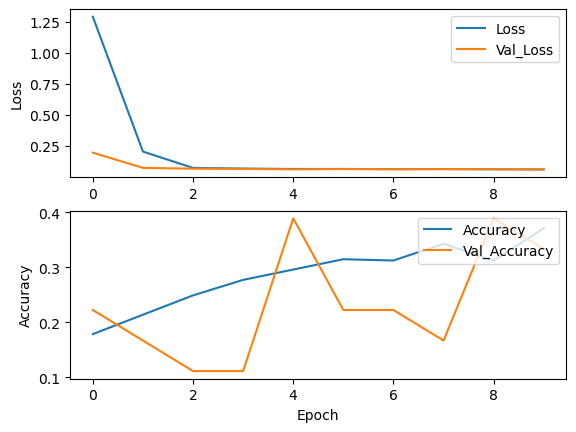

In [107]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Test the model

In [108]:
# Predict Classes

# divisible with 36: 2, 3, 4, 6, 9, 12, 18
test_batch_size = 3

target_names = list(train_generator.class_indices.keys())
print(target_names)
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=input_size[1:],
#     batch_size=test_batchsize,
    shuffle=True,
class_mode='categorical')

scores = model.evaluate(test_generator,workers=12)
target_names = list(test_generator.class_indices.keys())

['2', '3', '4a', '4b', '4c', '5']
Found 36 images belonging to 6 classes.
2/2 [==============================] - 43s 4s/step - loss: 1.5775 - accuracy: 0.1667


### Make predictions

In [109]:
test_generator.reset()

Y_pred = model.predict(test_generator, verbose=1)

y_pred = np.argmax(Y_pred, axis=-1)
classes = test_generator.classes

print(classes)
print(y_pred)

print(sum(y_pred==classes)/len(test_generator.classes))

2/2 [==============================] - 31s 3s/step
[0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5 5 5 5]
[3 3 3 5 5 5 2 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 5 3 3 3 5 3 3 3 3 3 2 3 3 3]
0.16666666666666666


### Confusion Matrix

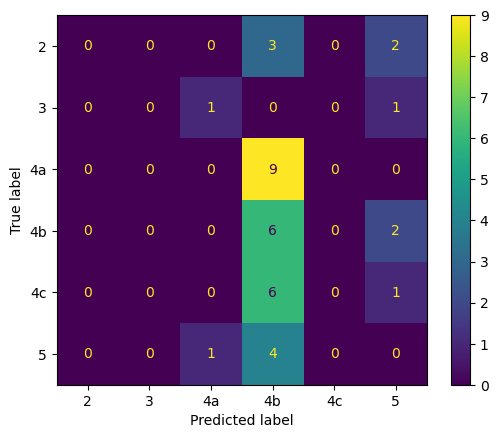

In [110]:

cm = confusion_matrix(classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot()
plt.grid(False)
plt.show()

### Metrics

In [111]:

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

def Average(FP):
    return sum(FP) / len(FP)
FP=Average(FP)


def Average1(FN):
    return sum(FN) / len(FN)
FN=Average1(FN)

def Average2(TP):
    return sum(TP) / len(TP)
TP=Average2(TP)

def Average3(TN):
    return sum(TN) / len(TN)
TN=Average3(TN)


print("True positive=",TP)
print("True Negative=",TN)
print("False positive=",FP)
print("False Negative=",FN)


True positive= 1.0
True Negative= 25.0
False positive= 5.0
False Negative= 5.0


In [112]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
#F1_SCORE
FSCO=(2*TP) / ((2*TP) +FP + FN) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [113]:
print("sensitivity=",round(TPR*100,3),"%")
print("precision=",round(PPV*100,3),"%")
print("Specificity=",round(TNR*100,3),"%")
print("F-score=", round(FSCO*100,3),"%")
print("ACCURACY=",round(ACC*100,3),"%")
print("FNR=",FNR*100,"%")
print("FPR=",FPR*100,"%")
print("NPV=",NPV*100,"%")

sensitivity= 16.667 %
precision= 16.667 %
Specificity= 83.333 %
F-score= 16.667 %
ACCURACY= 72.222 %
FNR= 83.33333333333334 %
FPR= 16.666666666666664 %
NPV= 83.33333333333334 %
